In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Sequential, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [3]:
print("GPUs Available: ", tf.config.experimental.list_physical_devices("GPU"))

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
raw_csv = "../input/digit-recognizer/train.csv"
test_csv = "../input/digit-recognizer/test.csv"

In [5]:
raw_df = pd.read_csv(raw_csv)
test_df = pd.read_csv(test_csv)

In [6]:
def get_image_and_label(data_frame):
    
    IMGs = data_frame.drop(["label"], axis = 1).values if 'label' in data_frame.columns else data_frame.values
    IMGs = np.array([image.reshape((28, 28)) for image in IMGs])
    IMGs = np.expand_dims(IMGs, axis = 3)
    
    labels = data_frame['label'].values if 'label' in data_frame.columns else None
    
    return IMGs, labels

In [7]:
raw_IMGs, raw_labels = get_image_and_label(raw_df)
test_IMGs, test_lables = get_image_and_label(test_df)

In [8]:
classes = len(set(raw_labels))
classes

10

In [9]:
raw_labels = to_categorical(raw_labels, num_classes = classes)
raw_labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [10]:
train_IMGs, validation_IMGs, train_labels, validation_labels = train_test_split(raw_IMGs, raw_labels, test_size = 0.1, random_state = 42)

In [11]:
print("Training Set Details:")
print(train_IMGs.shape)
print(train_labels.shape)
print("\n")

print("Validation Set Details:")
print(validation_IMGs.shape)
print(validation_labels.shape)
print("\n")

print("Testing Set Details:")
print(test_IMGs.shape)

Training Set Details:
(37800, 28, 28, 1)
(37800, 10)


Validation Set Details:
(4200, 28, 28, 1)
(4200, 10)


Testing Set Details:
(28000, 28, 28, 1)


In [12]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation = "relu", input_shape = (28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation = "relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation = "relu"),
    layers.BatchNormalization(),
    layers.Flatten(),
    
    layers.Dense(1024, activation = "relu"),
    layers.Dropout(0.2),
    
    layers.Dense(256, activation = "relu"),
    layers.Dropout(0.2),
    
    layers.Dense(64, activation = "relu"),
    layers.Dropout(0.2),
    
    layers.Dense(32, activation = "relu"),
    layers.Dropout(0.2),
    
    layers.Dense(16, activation = "relu"),
    layers.Dropout(0.2),
    
    layers.Dense(int(classes), activation = "softmax")
])

In [13]:
model.compile(loss = "categorical_crossentropy",
              optimizer = optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         7

In [15]:
train_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    shear_range = 0.1
)

validation_datagen = ImageDataGenerator(rescale = 1 / 255)

test_datagen = ImageDataGenerator(rescale = 1/ 255)

In [16]:
train_generator = train_datagen.flow(train_IMGs, train_labels, batch_size = 32)
validation_generator = train_datagen.flow(validation_IMGs,validation_labels, batch_size = 32)
test_generator = test_datagen.flow(test_IMGs, batch_size = 32, shuffle = False)

In [17]:
history = model.fit_generator(train_generator, epochs = 100, validation_data = validation_generator, verbose = 1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1182/1182 [==============================] - 21s 14ms/step - loss: 1.8215 - accuracy: 0.3519 - val_loss: 0.4915 - val_accuracy: 0.8686
Epoch 2/100
1182/1182 [==============================] - 16s 14ms/step - loss: 0.7031 - accuracy: 0.7694 - val_loss: 0.1838 - val_accuracy: 0.9555
Epoch 3/100
1182/1182 [==============================] - 16s 14ms/step - loss: 0.4148 - accuracy: 0.8821 - val_loss: 0.1309 - val_accuracy: 0.9667
Epoch 4/100
1182/1182 [==============================] - 16s 14ms/step - loss: 0.3183 - accuracy: 0.9133 - val_loss: 0.1152 - val_accuracy: 0.9733
Epoch 5/100
1182/1182 [==============================] - 16s 13ms/step - loss: 0.2587 - accuracy: 0.9310 - val_loss: 0.1142 - val_accuracy: 0.9726
Epoch 6/100
1182/1182 [==============================] - 16s 14ms/step - loss: 0.2253 - accuracy: 0.9416 - val_loss: 0.0902 - val_accuracy: 0.9807
Epoch 7/100
1182/1182 [==============================] - 16s 13ms/step - loss: 0.2056 - accuracy: 0.9506 - val_loss: 0

1182/1182 [==============================] - 17s 14ms/step - loss: 0.0613 - accuracy: 0.9860 - val_loss: 0.0600 - val_accuracy: 0.9893
Epoch 57/100
1182/1182 [==============================] - 16s 13ms/step - loss: 0.0634 - accuracy: 0.9863 - val_loss: 0.0554 - val_accuracy: 0.9905
Epoch 58/100
1182/1182 [==============================] - 16s 14ms/step - loss: 0.0641 - accuracy: 0.9861 - val_loss: 0.0486 - val_accuracy: 0.9902
Epoch 59/100
1182/1182 [==============================] - 15s 13ms/step - loss: 0.0544 - accuracy: 0.9871 - val_loss: 0.0453 - val_accuracy: 0.9902
Epoch 60/100
1182/1182 [==============================] - 17s 14ms/step - loss: 0.0644 - accuracy: 0.9869 - val_loss: 0.0394 - val_accuracy: 0.9900
Epoch 61/100
1182/1182 [==============================] - 16s 13ms/step - loss: 0.0565 - accuracy: 0.9865 - val_loss: 0.0513 - val_accuracy: 0.9914
Epoch 62/100
1182/1182 [==============================] - 16s 14ms/step - loss: 0.0688 - accuracy: 0.9853 - val_loss: 0.0516 

In [20]:
model.evaluate(validation_IMGs, validation_labels)

132/132 [==============================] - 0s 3ms/step - loss: 194.0744 - accuracy: 0.8421


[194.07443237304688, 0.8421428799629211]

In [22]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(accuracy))

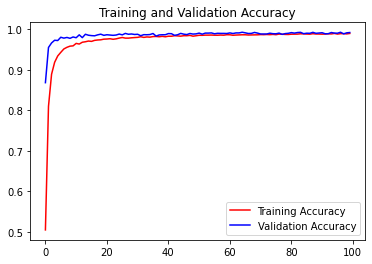

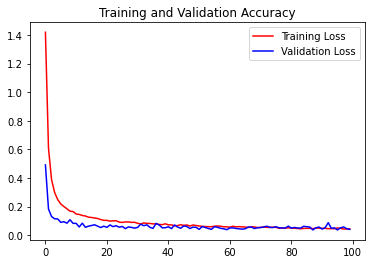

In [23]:
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [24]:
pred_labels = model.predict_generator(test_generator)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [25]:
pred_labels = np.argmax(pred_labels, axis=-1)
pred_labels

array([2, 0, 9, ..., 3, 9, 2])

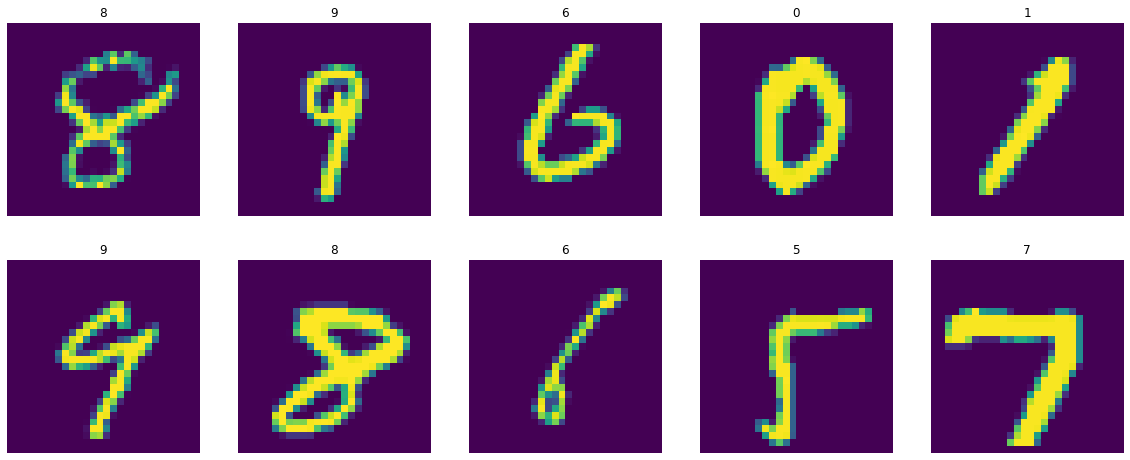

In [26]:
nrows = 2
ncols = 5

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

random_numbers = np.random.choice(range(len(pred_labels)), 10, replace=False)

rand_IMGs = [test_IMGs[num] for num in random_numbers]
rand_labels = [pred_labels[num] for num in random_numbers]

for i, img, label in zip(range(len(random_numbers)), rand_IMGs, rand_labels):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    
    plt.imshow(img[:,:,0])
    plt.title(label)

plt.show()

In [27]:
output = pd.DataFrame({'ImageId': test_df.index + 1, 'Label': pred_labels})
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [28]:
output.to_csv('submission.csv', index=False)